In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('cps4.csv')
df.head()
df.describe()

,wage,educ,exper
count,4838.000000,4838.000000,4838.000000
mean,20.135021,13.850351,25.896445
std,12.533806,2.733934,12.739166
min,1.000000,0.000000,1.000000
25%,11.270000,12.000000,15.000000
50%,16.600000,13.000000,26.000000
75%,25.000000,16.000000,36.000000
max,173.000000,21.000000,70.000000


In [29]:
df['log_wage'] = np.log(df['wage'])
y = df['log_wage']
x1 = df['educ']
x2 = df['exper']
X = df[['educ','exper']]
X_cons = sm.add_constant(X)

## OLS

In [30]:
x1_cons = sm.add_constant(x1)
x1_cons

,const,educ
0,1.0,16
1,1.0,12
2,1.0,16
3,1.0,14
4,1.0,12
...,...,...
4833,1.0,14
4834,1.0,14
4835,1.0,16
4836,1.0,12


In [31]:
model_1 = sm.OLS(y, X_cons).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     663.6
Date:                Sat, 18 Nov 2023   Prob (F-statistic):          2.14e-255
Time:                        20:42:06   Log-Likelihood:                -3594.1
No. Observations:                4838   AIC:                             7194.
Df Residuals:                    4835   BIC:                             7214.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3306      0.043     31.000      0.000       1.246       1.415
educ           0.0974      0.003     36.039      0.000       0.092       0.103
exper          0.0061      0.001     10.433      0.000       0.005       0.007
==============================================================================
Omnibus:                      179.309   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.693
Skew:                          -0.256   Prob(JB):                     3.90e-80
Kurtosis:                       4.246   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
residual = model_1.resid

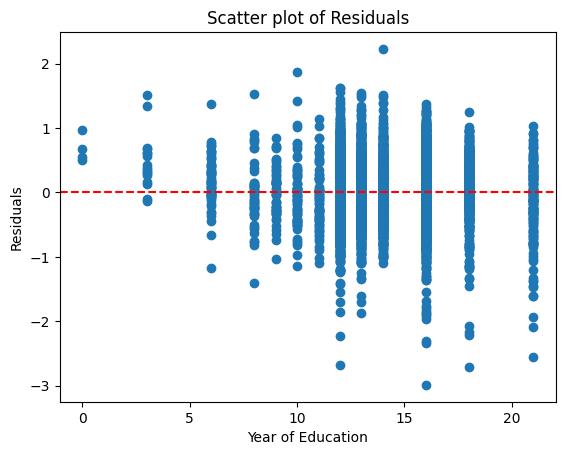

In [33]:
# Residual Plot
plt.scatter(x1, residual)
plt.title('Scatter plot of Residuals')
plt.xlabel('Year of Education')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')  # 잔차 0을 기준으로 한 수평선 추가
plt.show()

## 1. White Robust Standard Error

#### Robust standard error로 이분산성에 강건한 표준오차를 계산한다.

In [34]:
model_1 = sm.OLS(y, X_cons).fit(cov_type='HC0')
#ols_robust = model_1.get_robustcov_results(cov_type='HC0')

# cov_type은 HC0, HC1, HC2, HC3, HAC, cluster 등의 옵션을 제공합니다.
# 일반적으로 HC0이 가장 많이 알려져 있는 White Robust Standard Error 공식입니다.
# HC1부터는 sample size에 대해 자유도 조정을 한다고 합니다.
## See James G MacKinnon, Halbert White, "Some heteroskedasticity-consistent covariance matrix estimators with improved finite sample properties", Journal of Econometrics, Volume 29, Issue 3, 1985, Pages 305–325)

In [35]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     563.1
Date:                Sat, 18 Nov 2023   Prob (F-statistic):          1.44e-220
Time:                        20:42:06   Log-Likelihood:                -3594.1
No. Observations:                4838   AIC:                             7194.
Df Residuals:                    4835   BIC:                             7214.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3306      0.046     29.202      0.000       1.241       1.420
educ           0.0974      0.003     33.372      0.000       0.092       0.103
exper          0.0061      0.001      9.882      0.000       0.005       0.007
==============================================================================
Omnibus:                      179.309   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.693
Skew:                          -0.256   Prob(JB):                     3.90e-80
Kurtosis:                       4.246   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## 2. GLS/WLS

#### 예컨대, 교육수준 $(x_{1i})$에 따라 소득을 설명하는 정도가 달라진다고 볼 때

Assume that $\sigma_{i}^{2} = \exp (\delta_0 + \delta_1 x_{1i})$. Then,

1. Run OLS $y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \epsilon_i$ and get residual $e_i$.
2. Run OLS to $\log e_{i}^{2} = \delta_0 + \delta_1 x_{1i} + u_i$.
$(var(e_{i}) = E(e_{i}^{2}) = \exp(\hat{\delta_0}+\hat{\delta_1}x_{1i})$)
3. Run WLS to $y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \epsilon_i$ using $\hat{\sigma_{i}^{2}}=\exp (\hat{\delta_0}+\hat{\delta_1}x_{1i})$. 

In [36]:
residual = model_1.resid #Step 1은 여기서 끝

In [37]:
#step2: 잔차제곱 로그를 x1에 회귀분석
residual_sq = residual**2
log_residual = np.log(residual_sq)
x1_cons = sm.add_constant(x1)
model_aux = sm.OLS(log_residual, x1_cons).fit()
model_aux.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.457
Date:                Sat, 18 Nov 2023   Prob (F-statistic):            0.00634
Time:                        20:42:06   Log-Likelihood:                -10783.
No. Observations:                4838   AIC:                         2.157e+04
Df Residuals:                    4836   BIC:                         2.158e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1435      0.167    -18.834      0.000      -3.471      -2.816
educ           0.0323      0.012      2.731      0.006       0.009       0.055
==============================================================================
Omnibus:                     1405.371   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4561.835
Skew:                          -1.466   Prob(JB):                         0.00
Kurtosis:                       6.746   Cond. No.                         73.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
log_sigma2 = model_aux.predict() #잔차제곱로그 예측
log_sigma2

array([-2.62695715, -2.7560974 , -2.62695715, ..., -2.62695715,
       -2.7560974 , -2.62695715])

In [39]:
sigma2_hat = np.exp(log_sigma2) #로그 풀어주고 잔차제곱 예측
sigma_hat = np.sqrt(sigma2_hat) #제곱 풀어줌
sigma_hat

array([0.2688831 , 0.25206994, 0.2688831 , ..., 0.2688831 , 0.25206994,
       0.2688831 ])

In [42]:
model_gls = sm.GLS(y, X_cons, sigma_hat).fit()

In [43]:
model_gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.214
Model:                            GLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     656.9
Date:                Sat, 18 Nov 2023   Prob (F-statistic):          4.22e-253
Time:                        20:42:15   Log-Likelihood:                -3583.9
No. Observations:                4838   AIC:                             7174.
Df Residuals:                    4835   BIC:                             7193.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3398      0.043     31.437      0.000       1.256       1.423
educ           0.0968      0.003     35.877      0.000       0.092       0.102
exper          0.0060      0.001     10.433      0.000       0.005       0.007
==============================================================================
Omnibus:                      154.753   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.009
Skew:                          -0.224   Prob(JB):                     2.16e-67
Kurtosis:                       4.150   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
model_wls = sm.WLS(y, X_cons, weights = 1/sigma_hat)

In [46]:
result = model_wls.fit()

In [47]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.214
Model:                            WLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     656.9
Date:                Sat, 18 Nov 2023   Prob (F-statistic):          4.22e-253
Time:                        20:43:40   Log-Likelihood:                -3583.9
No. Observations:                4838   AIC:                             7174.
Df Residuals:                    4835   BIC:                             7193.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3398      0.043     31.437      0.000       1.256       1.423
educ           0.0968      0.003     35.877      0.000       0.092       0.102
exper          0.0060      0.001     10.433      0.000       0.005       0.007
==============================================================================
Omnibus:                      154.753   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.009
Skew:                          -0.224   Prob(JB):                     2.16e-67
Kurtosis:                       4.150   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""